# Clustering ISGs  for HBECs

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

import statsmodels.formula.api as smf
import statsmodels.api as sm
pd.set_option('display.max_rows', 600)

In [2]:
import functools

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.7-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [4]:
data_path = '/data_volume/memento/hbec/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [6]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'large',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Get data

In [7]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [8]:
# adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [9]:
adata.shape

(69958, 36601)

In [10]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [11]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])
# adata_processed.obs['ct'] = adata_processed.obs['cell_type'].apply(lambda x: converter[x])

### Setup memento

In [12]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [13]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [14]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

### Read 1D HT results

In [15]:
cts = ['C', 'B', 'BC', 'all_ct']
tps = [ '3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [16]:
def read_result():
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        adata_subset = sc.read(data_path + '/binary_test_latest/C_{}_6.h5ad'.format(stim))
        ht_dict[stim] = memento.get_1d_ht_result(adata_subset)
        ht_dict[stim]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim]['de_pval'])
        ht_dict[stim]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim]['dv_pval'])
        moments_dict[stim] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [17]:
ht, moments = read_result()

In [18]:
t1_de_genes = ht['beta'].query('de_coef > 0.5 & de_fdr < 0.05')
t2_de_genes = ht['gamma'].query('de_coef > 0.5 & de_fdr < 0.05')

### Coexpression

In [19]:
def get_gxg_matrix(adata, genes):

    memento.compute_2d_moments(adata, list(itertools.combinations(genes, 2)))
    
    moments = memento.get_2d_moments(adata, groupby='group')
    
    gxg_matrix = pd.DataFrame(index=genes, columns=genes)
    for idx, row in moments.iterrows():
        gxg_matrix.loc[row['gene_1'], row['gene_2']] = row['group_1']
        gxg_matrix.loc[row['gene_2'], row['gene_1']] = row['group_1']
    gxg_matrix = gxg_matrix.fillna(0.0)
#     gxg_matrix = moments.pivot('gene_1', 'gene_2', 'group_1').fillna(0.0)
#     gxg_matrix[gxg_matrix.columns] = gxg_matrix.values + gxg_matrix.values.T
    gxg_matrix = gxg_matrix.loc[list(set(gxg_matrix.columns) & set(gxg_matrix.index)), list(set(gxg_matrix.columns) & set(gxg_matrix.index))]
    
    return gxg_matrix

In [210]:
ct = ['C']
adata_ctrl = adata.copy()[
    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin(['control'])].copy()
adata_stim = adata.copy()[
    adata.obs.time.isin(['6']) & \
    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin(['beta'])].copy()
adata_gamma = adata.copy()[
    adata.obs.time.isin(['6']) & \
    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin(['gamma'])].copy()
adata_ctrl.obs['group'] = 1
adata_stim.obs['group'] = 1
adata_gamma.obs['group'] = 1

memento.create_groups(adata_ctrl, label_columns=['donor', 'group'])
memento.compute_1d_moments(adata_ctrl, min_perc_group=.9)
memento.create_groups(adata_stim, label_columns=['donor', 'group'])
memento.compute_1d_moments(adata_stim, min_perc_group=.9)
memento.create_groups(adata_gamma, label_columns=['donor', 'group'])
memento.compute_1d_moments(adata_gamma, min_perc_group=.9)


gene_list = list( set(adata_ctrl.var.index) & set(adata_stim.var.index) & set(t1_de_genes.gene.tolist() )  & set(adata_gamma.var.index) )

ctrl_gxg = get_gxg_matrix(adata_ctrl, gene_list)
stim_gxg = get_gxg_matrix(adata_stim, gene_list)
gamma_gxg = get_gxg_matrix(adata_gamma, gene_list)

### Cluster the stim data, see the control-stim matched correlations

In [21]:
from sklearn.cluster import AgglomerativeClustering

In [22]:
# num_cluster = 4

In [23]:
# working params: distance_threshold=15
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=15).fit(ctrl_gxg.clip(upper=1, lower=-1))
# keep cluster 3
for cluster in range(clustering.labels_.max()+1):
    selector = np.where(clustering.labels_==cluster)[0]
    selected_stim_gxg = stim_gxg.iloc[selector, selector]
    selected_ctrl_gxg = ctrl_gxg.iloc[selector, selector]

    print(cluster, selector.shape[0], selected_stim_gxg.mean().mean(), selected_ctrl_gxg.mean().mean())
with open('ctrl_clustering.pkl','wb') as f:
    pkl.dump(clustering, f)

0 66 0.2693050983091501 0.11935129156523391
1 66 0.21158346559875335 0.15156131313703117
2 73 0.3122118074614755 0.2701744672586199
3 36 0.4292436543388385 0.30792329653228273
4 28 0.4063141517340658 0.3745589686749486
5 40 0.24972196490147244 0.21407262341368619
6 103 0.14404064483793977 0.0398876368347973
7 72 0.5704343368481161 0.5361414948166875
8 32 0.17990344601657304 0.12579022689404232
9 43 0.34588756500812323 0.2710136154219226
10 56 0.4475450290227311 0.43126786908154086
11 1 0.0 0.0
12 1 0.0 0.0


In [24]:
clustering.labels_[ctrl_gxg.index.tolist().index('STAT2')]

2

In [25]:
clustering.labels_[ctrl_gxg.index.tolist().index('MX1')]

7

In [26]:
canonical_genes = ctrl_gxg.index[clustering.labels_==7].tolist() #+ ctrl_gxg.index[clustering.labels_==10].tolist()

In [27]:
print(canonical_genes)

['CMPK2', 'BST2', 'APOL1', 'ISG15', 'PSMB8', 'NT5C3A', 'IFIT1', 'IDO1', 'IFI6', 'ETV7', 'IRF9', 'ISG20', 'RSAD2', 'APOBEC3G', 'SAMD9L', 'DDX60L', 'RTP4', 'IFI16', 'OPTN', 'SPATS2L', 'LAP3', 'MX1', 'TRIM22', 'MX2', 'GBP4', 'DDX60', 'IFIT3', 'CD38', 'PARP12', 'HERC6', 'PSMB9', 'WARS', 'APOL6', 'IFI44L', 'MYD88', 'TAP1', 'PARP9', 'U62317.4', 'PLAAT2', 'IFI44', 'SP100', 'STAT1', 'USP18', 'UBE2L6', 'IFIH1', 'SAMD9', 'EPSTI1', 'OAS1', 'IFIT2', 'HERC5', 'IRF7', 'GBP1', 'HLA-E', 'OAS2', 'XAF1', 'IFI35', 'PARP14', 'PLSCR1', 'IFITM1', 'HELZ2', 'NUB1', 'ADAR', 'NUPR1', 'IFI27', 'EIF2AK2', 'IFITM3', 'DDX58', 'SHFL', 'SP110', 'OAS3', 'OASL', 'RNF213']


In [28]:
'PARP6' in gene_list

False

In [29]:
subset_stim_gxg = stim_gxg.loc[list(set(stim_gxg.index)-set(canonical_genes)), : ].loc[: , list(set(stim_gxg.index)-set(canonical_genes))]
subset_ctrl_gxg = ctrl_gxg.loc[list(set(stim_gxg.index)-set(canonical_genes)), : ].loc[: , list(set(stim_gxg.index)-set(canonical_genes))]

In [30]:
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=15).fit(subset_stim_gxg.clip(upper=1, lower=-1))

# keep cluster 3
for cluster in range(clustering.labels_.max()+1):
    selector = np.where(clustering.labels_==cluster)[0]
    selected_subset_stim_gxg = subset_stim_gxg.iloc[selector, selector]
    selected_subset_ctrl_gxg = subset_ctrl_gxg.iloc[selector, selector]

    print(cluster, selector.shape[0], selected_subset_stim_gxg.mean().mean(), selected_subset_ctrl_gxg.mean().mean())
with open('stim_clustering.pkl','wb') as f:
    pkl.dump(clustering, f)

0 60 0.5854549681731078 0.2979394534123458
1 72 0.5198784498481381 0.1816760657861928
2 61 0.4277474059895701 0.16576665584190364
3 80 0.25365029533779865 0.13394642691289763
4 28 0.09001529855008138 0.0565566900076162
5 77 0.29462408704269316 0.1859810320290982
6 40 0.17728060425808792 0.08807475227780069
7 46 0.2657231000746266 0.07287158191130723
8 46 0.398602467633561 0.1691232498637102
9 35 0.21539205358235197 0.056911846972086476


In [32]:
clustering.labels_[subset_stim_gxg.index.tolist().index('HLA-A')]

1

In [33]:
noncanonical_genes_1 = subset_stim_gxg.index[clustering.labels_==1].tolist()
noncanonical_genes_2 = subset_stim_gxg.index[clustering.labels_==2].tolist()

noncanonical_genes_3 = subset_stim_gxg.index[clustering.labels_==8].tolist()

# noncanonical_genes_2 = subset_stim_gxg.index[clustering.labels_==6].tolist()

In [197]:
all_selected_genes = canonical_genes + noncanonical_genes_1 + noncanonical_genes_3 + noncanonical_genes_2

In [198]:
np.fill_diagonal(ctrl_gxg.values, 1)
np.fill_diagonal(stim_gxg.values, 1)

([], [])

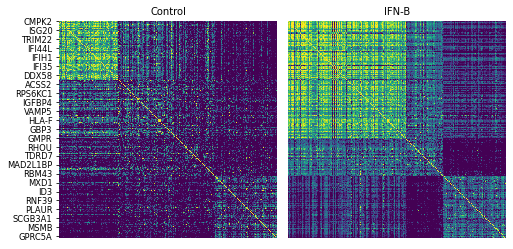

In [199]:
plt.figure(figsize=(8,4))
plt.subplots_adjust(wspace=0.05)

plt.subplot(1, 2, 1);
plt.title('Control')
sns.heatmap(ctrl_gxg.loc[all_selected_genes, all_selected_genes], vmin=0.1, vmax=0.8, cmap='viridis', cbar=None)
plt.axis('equal')
plt.xticks([])

plt.subplot(1, 2, 2);
plt.title('IFN-B')
sns.heatmap(stim_gxg.loc[all_selected_genes, all_selected_genes], vmin=0.1, vmax=0.8, cmap='viridis', cbar=None)
plt.axis('equal')
plt.xticks([])
plt.yticks([])

In [ ]:
sns.heatmap(gamma_gxg.loc[all_selected_genes, all_selected_genes], vmin=0.1, vmax=0.8, cmap='viridis', cbar=None)
plt.axis('equal')
plt.xticks([])
plt.yticks([])

In [150]:
moments['beta'][1].query('gene in @canonical_genes')['time_step_0'].median()

0.7483176350945286

In [188]:
mc = np.exp(moments['beta'][0].query('gene in @canonical_genes')['time_step_0'])
vc = np.sqrt(np.exp(moments['beta'][1].query('gene in @canonical_genes')['time_step_0']))

mc2 = np.exp(moments['beta'][0].query('gene in @noncanonical_genes_1')['time_step_0'])
vc2 = np.sqrt(np.exp(moments['beta'][1].query('gene in @noncanonical_genes_1')['time_step_0']))

ms = np.exp(moments['beta'][0].query('gene in @canonical_genes')['time_step_1'])
vs = np.sqrt(np.exp(moments['beta'][1].query('gene in @canonical_genes')['time_step_1']))

ms2 = np.exp(moments['beta'][0].query('gene in @noncanonical_genes_1')['time_step_1'])
vs2 = np.sqrt(np.exp(moments['beta'][1].query('gene in @noncanonical_genes_1')['time_step_1']))

Text(0, 0.5, 'Variability')

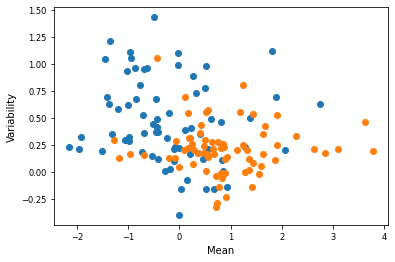

In [205]:
plt.scatter(np.log(mc), np.log(vc))
plt.scatter(np.log(ms), np.log(vs))
plt.xlabel('Mean')
plt.ylabel('Variability')

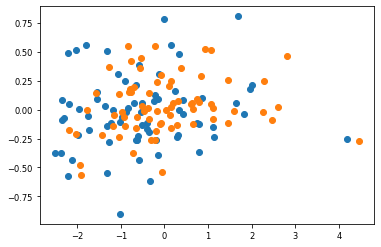

In [211]:
plt.scatter(np.log(mc2), np.log(vc2))
plt.scatter(np.log(ms2), np.log(vs2))

In [152]:
stats.mannwhitneyu(vc, vc2)

MannwhitneyuResult(statistic=1071.0, pvalue=5.246738931315645e-11)

(-3.0, 80.0)

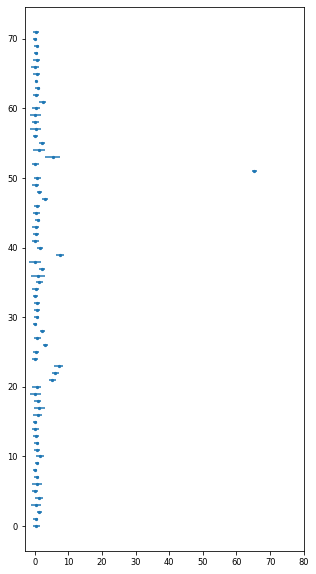

In [206]:
plt.figure(figsize=(5, 10))
plt.scatter(mc2, np.arange(mc2.shape[0]), s=5)
plt.errorbar(mc2, np.arange(mc2.shape[0]),ls='none',xerr=vc2)
plt.xlim(-3, 80)


(-3.0, 80.0)

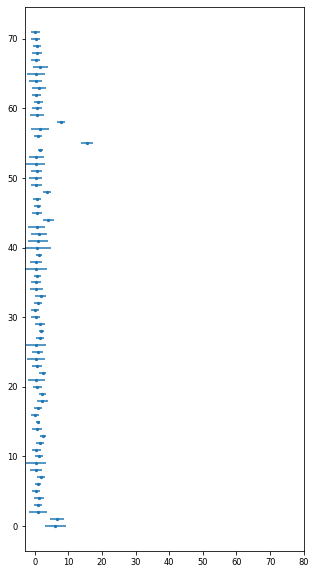

In [207]:
plt.figure(figsize=(5, 10))
plt.scatter(mc, np.arange(mc.shape[0]), s=5)
plt.errorbar(mc, np.arange(mc.shape[0]),ls='none',xerr=vc)
plt.xlim(-3, 80)


### Tonic sensitivity

In [155]:
tonic_sensitivity_df = pd.read_csv('tonic_isg.txt', sep='\t')
tonic_sensitivity_df['gene'] = tonic_sensitivity_df['GeneSymbol'].str.upper()
tonic_sensitivity_df = tonic_sensitivity_df[['gene', 'TonicIndex']].rename(columns={'TonicIndex':'Tonic Sensitivity'})

In [156]:
tonic_sensitivity_df['Tonic Sensitivity'] = np.log(tonic_sensitivity_df['Tonic Sensitivity'])

In [157]:
tonic_sensitivity_df = tonic_sensitivity_df.query('gene in @all_selected_genes').copy()

In [158]:
tonic_sensitivity_df.shape

(53, 2)

In [159]:
tonic_sensitivity_df['group'] = tonic_sensitivity_df['gene'].apply(lambda x: 'canon' if x in canonical_genes else 'non-canon')

In [160]:
tonic_sensitivity_df.group.value_counts()

canon        50
non-canon     3
Name: group, dtype: int64

<AxesSubplot:xlabel='group', ylabel='Tonic Sensitivity'>

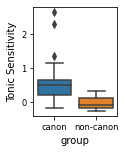

In [161]:
plt.figure(figsize=(1.5,2))
sns.boxplot(x='group', y='Tonic Sensitivity', data=tonic_sensitivity_df)

In [162]:
stats.mannwhitneyu(tonic_sensitivity_df.query('group == "canon"')['Tonic Sensitivity'], tonic_sensitivity_df.query('group == "non-canon"')['Tonic Sensitivity'])

MannwhitneyuResult(statistic=20.0, pvalue=0.017950614118426366)

### Baseline variability

In [169]:
baseline = moments['beta'][1].query('gene in @all_selected_genes').copy()

In [170]:
baseline['group'] = baseline['gene'].apply(lambda x: 'canon' if x in canonical_genes else 'non-canon')

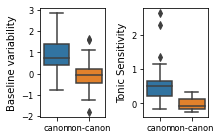

In [172]:
plt.figure(figsize=(3,2))
plt.subplots_adjust(wspace=0.6)

plt.subplot(1, 2, 1)
sns.boxplot(x='group', y='time_step_0', data=baseline);
plt.xlabel(None);
plt.ylabel('Baseline variability')
plt.subplot(1, 2, 2)

sns.boxplot(x='group', y='Tonic Sensitivity', data=tonic_sensitivity_df)
plt.xlabel(None);
